In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from wipy.wipy_utils import utils

In [2]:
# load Geogiga velocity model

FATT_path = "Field-Data/FATT-Model/Vp.xzv"

VP_init = np.loadtxt(FATT_path)

VP_init[VP_init[:,2] < 450, 2] = 450
VP_init[VP_init[:,2] > 5000, 2] = 5000

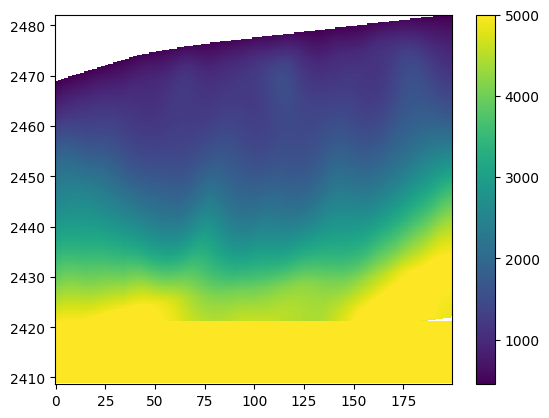

In [3]:
# grid the xzv vector

Xg, Zg = np.meshgrid(
    np.arange(np.min(VP_init[:,0]), np.max(VP_init[:,0]), 0.25),
    np.arange(np.min(VP_init[:,1]), np.max(VP_init[:,1]), 0.25),
    )

Vg = scipy.interpolate.griddata(VP_init[:,0:2], VP_init[:,2], (Xg, Zg), method='linear')

Vg[1:50,:] = 5000.0

plt.pcolormesh(Xg, Zg, Vg)
plt.colorbar()


In [4]:
# pad the left and rigt sides of grided arrays so that the interpolation doesn't introduce Nan values

z_uniq = np.unique(Zg)

x_min = np.min(Xg)
x_max = np.max(Xg)

ext = 30

pad_l = []
pad_r = []

for z_u in z_uniq:
    
    pl = [x_min-ext, z_u, Vg[(Zg == z_u) & (Xg == x_min)][0]]
    pad_l.append(pl)

    pr = [x_max+ext, z_u, Vg[(Zg == z_u) & (Xg == x_max)][0]]
    pad_r.append(pr)
    

pad_l = np.array(pad_l)
pad_r = np.array(pad_r)

In [5]:
# pad the top and bottom of grided arrays so that the interpolation doesn't introduce Nan values

x_uniq = np.unique(Xg)

z_min = np.min(Zg)
z_max = np.max(Zg)

ext = 30

pad_t = []
pad_b = []

for x_u in x_uniq:
    
    pt = [x_u, z_max+ext, np.nanmin(Vg[(Xg == x_u)])]
    pad_t.append(pt)

    pb = [x_u, z_min-ext, np.nanmax(Vg[(Xg == x_u)])]
    pad_b.append(pb)
    

pad_t = np.array(pad_t)
pad_b = np.array(pad_b)

In [6]:
# make arrays for interpolation

points = np.vstack((Xg.flatten(), Zg.flatten())).T

points = np.vstack((pad_l[:,0:2], pad_t[:,0:2], pad_b[:,0:2], pad_r[:,0:2], points))

values = Vg.flatten()

values = np.hstack((pad_l[:,2].T, pad_t[:,2], pad_b[:,2], pad_r[:,2].T, values))


In [7]:
# do nan-masking

nan_mask = ~np.isnan(values)
values = values[nan_mask]
points = points[nan_mask, :]

In [14]:
# plt.scatter(points[:,0], points[:,1], c = np.isnan(values))

In [9]:
# make an interpolation function for the velocity model

VP_interp = scipy.interpolate.LinearNDInterpolator(points=points, values=values)

(<Figure size 1000x1000 with 2 Axes>, <Axes: >)

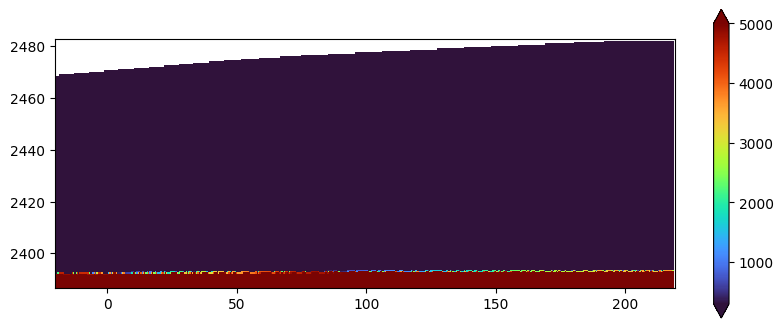

In [10]:
# load the skeleton spcefem model

init_model_path = "model_init"

pars = ["x", "z", "vp", "vs", "rho"]

m = utils.load_model(init_model_path, pars)

utils.plot_model_fast(m, 0.5, "vp")

(<Figure size 1000x1000 with 2 Axes>, <Axes: >)

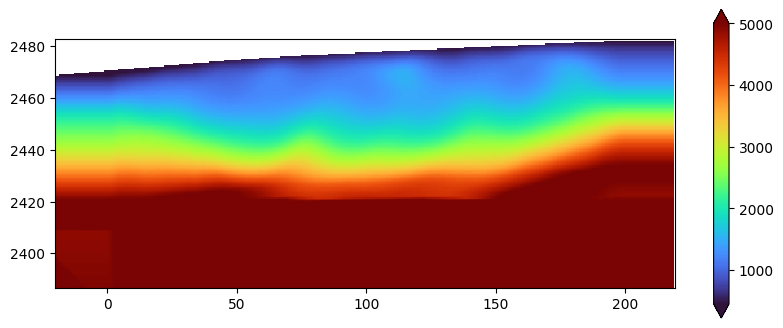

In [17]:
m["vp"] = VP_interp(m["x"], m["z"])
m["vp"][np.isnan(m["vp"])] = 5000.0

utils.plot_model_fast(m, 0.5, "vp", bounds = [450, 5000])
# utils.plot_model(m, 25, "vp")


In [18]:
# set vs
m["vs"] = m["vp"]/2
bol = m["vs"] < 250
m["vs"][bol] = 250 

# set rho
m["rho"] = np.ones(len(m["vp"]))*1000

Text(0, 0.5, 'elevation [m]')

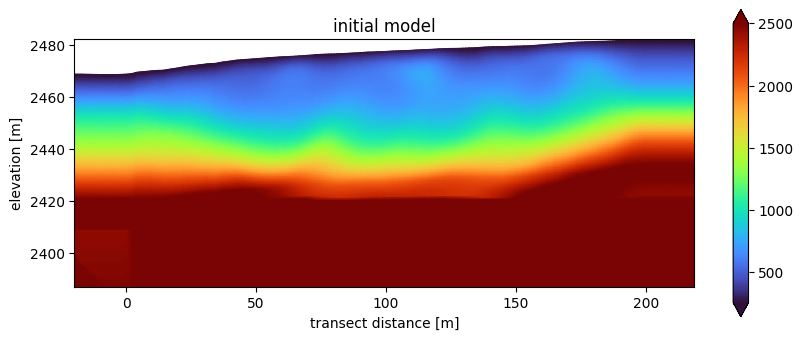

In [20]:
# plot model

fig, ax = utils.plot_model(m, 25, "vs", cmap="turbo")

ax.set_title("initial model")
ax.set_xlabel("transect distance [m]")
ax.set_ylabel("elevation [m]")

In [21]:
# # write model 

utils.write_model(model_path=init_model_path, model=m)